#### Load and preprocess stock data from CSV

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from datetime import datetime

# Read the CSV file
def load_stock_data(filename):
    # Load your dataset
    df = pd.read_csv(filename)

    # Clean column names (remove extra spaces)
    df.columns = df.columns.str.strip()
    df = df.drop(columns=["Volume"])  # Removes the "Volume" column
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Clean price columns (remove $ and convert to float)
    price_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_columns:
        df[col] = df[col].str.replace('$', '').astype(float)

    # Sort by date
    df = df.sort_values('Date')
    df = df.reset_index(drop=True)

    return df

df = load_stock_data(filename='./historical data/AAPL_5_yrs.csv')

In [45]:
print(df.head())

        Date  Close/Last     Open     High      Low  Close_Smooth  ATR  \
0 2020-06-04     80.5800  81.0975  81.4050  80.1950     80.352607  NaN   
1 2020-06-05     82.8750  80.8375  82.9375  80.8075     83.068467  NaN   
2 2020-06-08     83.3650  82.5625  83.4000  81.8300     84.544114  NaN   
3 2020-06-09     85.9975  83.0350  86.4025  83.0025     85.256674  NaN   
4 2020-06-10     88.2100  86.9750  88.6925  86.5225     85.567634  NaN   

       MA5  MA21  
0      NaN   NaN  
1      NaN   NaN  
2      NaN   NaN  
3      NaN   NaN  
4  84.2055   NaN  


In [9]:
# Calculate ATR (Average True Range) for dynamic threshold
def calculate_atr(df, period=14):
    """Calculate Average True Range for volatility-based thresholds"""
    high = df['High']
    low = df['Low']
    close = df['Close/Last']
    
    # True Range calculation
    tr1 = high - low                # High - Low: The current day's price range.
    tr2 = abs(high - close.shift()) # abs(High - Previous Close): The price gap between today’s high and the previous day’s close.
    tr3 = abs(low - close.shift())  # abs(Low - Previous Close): The price gap between today’s low and the previous day’s close.
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # ATR is the rolling mean of TR
    atr = tr.rolling(window=period).mean() # defaut is 14
    
    return atr



#### Detect peak and troughs

In [82]:
def detect_extrema(df, window=49, polyorder=5, distance=15, prominence_factor=0.5, refine_window=3):
    """
    Detect significant peaks and troughs in price data with refinement on raw prices.
    
    Parameters:
    - window: smoothing window size
    - polyorder: polynomial order for Savitzky-Golay filter
    - distance: minimum distance between peaks
    - prominence_factor: factor of ATR used for prominence
    - refine_window: how many bars left/right to search for the exact high/low
    """

    # Step 1: Smooth the signal
    df['Close_Smooth'] = savgol_filter(df['Close/Last'], window, polyorder)

    # Step 2: Compute ATR and set prominence threshold
    df['ATR'] = calculate_atr(df)
    atr_median = df['ATR'].median()
    prominence = atr_median * prominence_factor

    # Step 3: Initial peak detection on smoothed data
    raw_peaks, peak_properties = find_peaks(
        df['Close_Smooth'], distance=distance, prominence=prominence, width=3
    )
    raw_troughs, trough_properties = find_peaks(
        -df['Close_Smooth'], distance=distance, prominence=prominence, width=3
    )

    # Step 4: Refine peak positions by searching in raw prices
    def refine_peak(idx):
        start = max(idx - refine_window, 0)
        end = min(idx + refine_window + 1, len(df))
        return df['Close/Last'].iloc[start:end].idxmax()

    def refine_trough(idx):
        start = max(idx - refine_window, 0)
        end = min(idx + refine_window + 1, len(df))
        return df['Close/Last'].iloc[start:end].idxmin()

    peaks_idx = sorted(set(refine_peak(i) for i in raw_peaks))
    troughs_idx = sorted(set(refine_trough(i) for i in raw_troughs))

    return peaks_idx, troughs_idx, peak_properties, trough_properties


peaks_idx, troughs_idx, peak_properties, trough_properties = detect_extrema(df, window=7, polyorder=6, distance=15, prominence_factor=0.5)

In [84]:
def create_inflexion_dataframe(df, peaks_idx, troughs_idx):
    """
    Create a dataframe of inflexion points combining peaks and troughs
    """
    inflexion_data = []
    
    # Add peaks
    for idx in peaks_idx:
        inflexion_data.append({
            'Date': df.loc[idx, 'Date'],
            'InflexionPrice': df.loc[idx, 'Close/Last'],  # Actual closing price
            'point': 'high',
            'index': idx,
            '5_day_mean': df.loc[idx, 'MA5'],  # Use pre-calculated MA5
            '21_day_mean': df.loc[idx, 'MA21']  # Use pre-calculated MA21
        })
    
    # Add troughs
    for idx in troughs_idx:
        inflexion_data.append({
            'Date': df.loc[idx, 'Date'],
            'InflexionPrice': df.loc[idx, 'Close/Last'],  # Actual closing price
            'point': 'low',
            'index': idx,
            '5_day_mean': df.loc[idx, 'MA5'],  # Use pre-calculated MA5
            '21_day_mean': df.loc[idx, 'MA21']  # Use pre-calculated MA21
        })
    
    # Create dataframe and sort by date
    df_inflex = pd.DataFrame(inflexion_data)
    df_inflex = df_inflex.sort_values('Date').reset_index(drop=True)
    
    return df_inflex

df_inflex = create_inflexion_dataframe(df, peaks_idx, troughs_idx)

In [85]:
print(df_inflex)

         Date  InflexionPrice point  index  5_day_mean  21_day_mean
0  2020-07-24          92.615   low     35      95.618    94.195119
1  2020-09-01         134.180  high     62     127.912   118.501786
2  2020-09-18         106.840   low     74     112.041   120.093452
3  2020-10-12         124.400  high     90     116.916   113.593571
4  2020-11-02         108.770   low    105     112.150   116.192857
..        ...             ...   ...    ...         ...          ...
69 2025-02-24         247.100  high   1186     245.564   236.622381
70 2025-03-13         209.680   low   1199     222.810   236.973333
71 2025-04-02         223.890  high   1213     222.192   221.422857
72 2025-04-08         172.420   low   1217     193.868   212.271905
73 2025-05-01         213.320  high   1233     211.290   200.713810

[74 rows x 6 columns]


#### Visualize high and low point

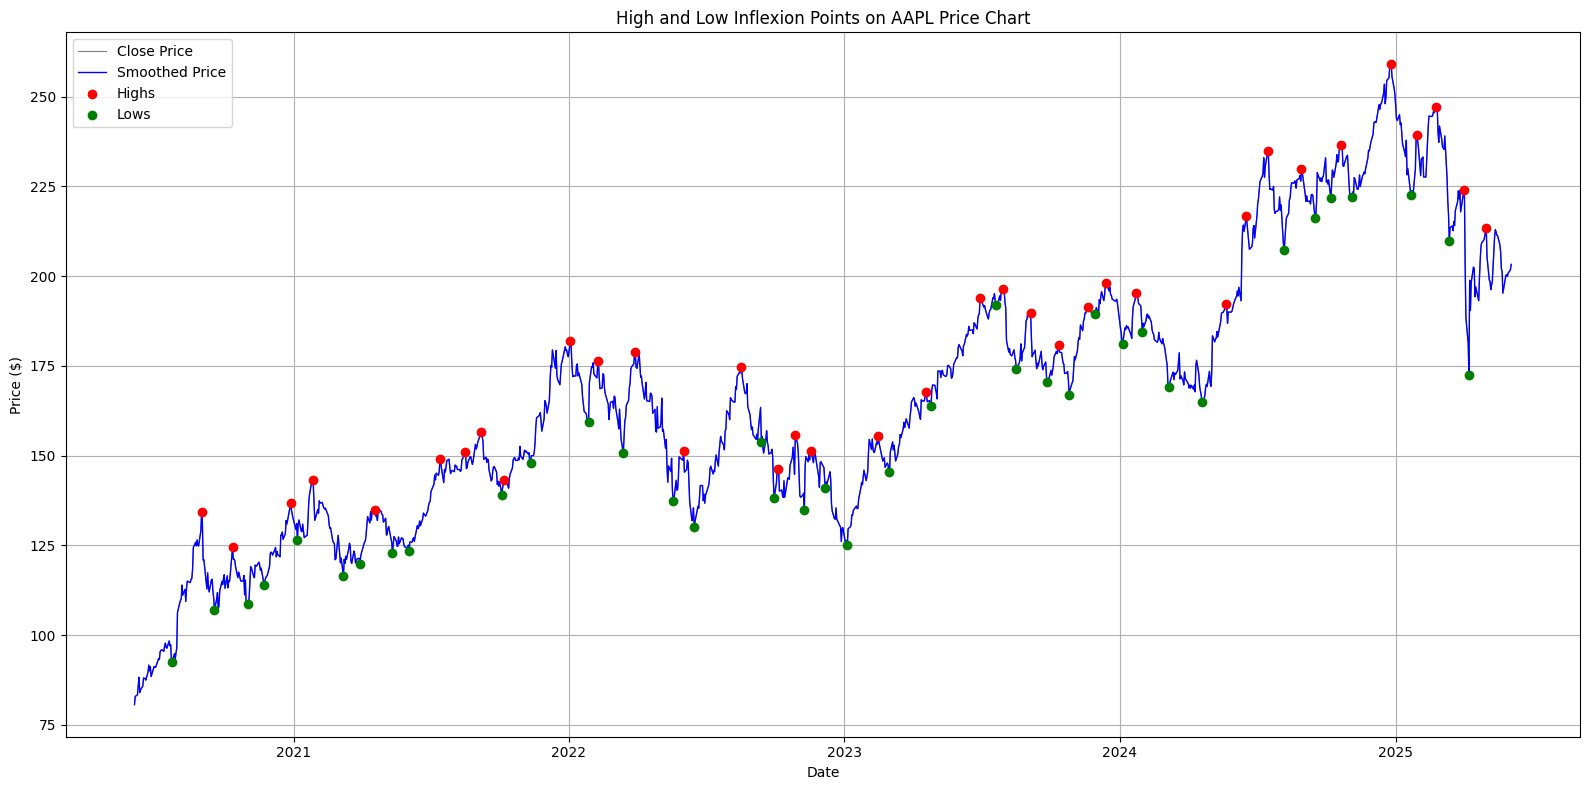

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df and df_inflex are already loaded and parsed with 'Date' as datetime

# Plot main price series
plt.figure(figsize=(16, 8))
plt.plot(df["Date"], df["Close/Last"], label="Close Price", color='gray', linewidth=0.8)
plt.plot(df["Date"], df["Close_Smooth"], label="Smoothed Price", color='blue', linewidth=1)

# Extract highs and lows from df_inflex
highs = df_inflex[df_inflex["point"] == "high"]
lows = df_inflex[df_inflex["point"] == "low"]

# Plot highs and lows
plt.scatter(highs["Date"], highs["InflexionPrice"], color='red', label="Highs", zorder=5)
plt.scatter(lows["Date"], lows["InflexionPrice"], color='green', label="Lows", zorder=5)

# Final plot touches
plt.title("High and Low Inflexion Points on AAPL Price Chart")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Trend analysis

##### Find HH, HL, LH, LL

In [93]:
def classify_trend_structure(df, peaks_idx, troughs_idx):
    points = []

    for i in peaks_idx:
        points.append({'index': i, 'price': df['Close/Last'].iloc[i], 'type': 'high'})
    for i in troughs_idx:
        points.append({'index': i, 'price': df['Close/Last'].iloc[i], 'type': 'low'})

    # Sort by index (time order)
    points = sorted(points, key=lambda x: x['index'])

    last_high = None
    last_low = None
    trend = None  # Can be 'bullish', 'bearish', or None
    labeled_points = []

    for pt in points:
        idx = pt['index']
        price = pt['price']
        ptype = pt['type']

        if ptype == 'low':
            if last_low is None:
                label = 'L'
            elif price > last_low:
                label = 'HL'
                trend = 'bullish'
            else:
                label = 'LL'
                trend = 'bearish'
            last_low = price

        elif ptype == 'high':
            if last_high is None:
                label = 'H'
            elif trend == 'bullish':
                if price > last_high:
                    label = 'HH'
                else:
                    label = 'H'  # Not yet a LH unless confirmed by a LL
            elif trend == 'bearish':
                if price < last_high:
                    label = 'LH'
                else:
                    label = 'H'  # Not yet a HH unless confirmed by HL
            else:
                label = 'H'  # No trend established yet
            last_high = price

        labeled_points.append({
            'index': idx,
            'price': price,
            'type': ptype,
            'label': label
        })

    return pd.DataFrame(labeled_points)


structure_df = classify_trend_structure(df, peaks_idx, troughs_idx)



##### Visualization on HH,HL,LH,LL

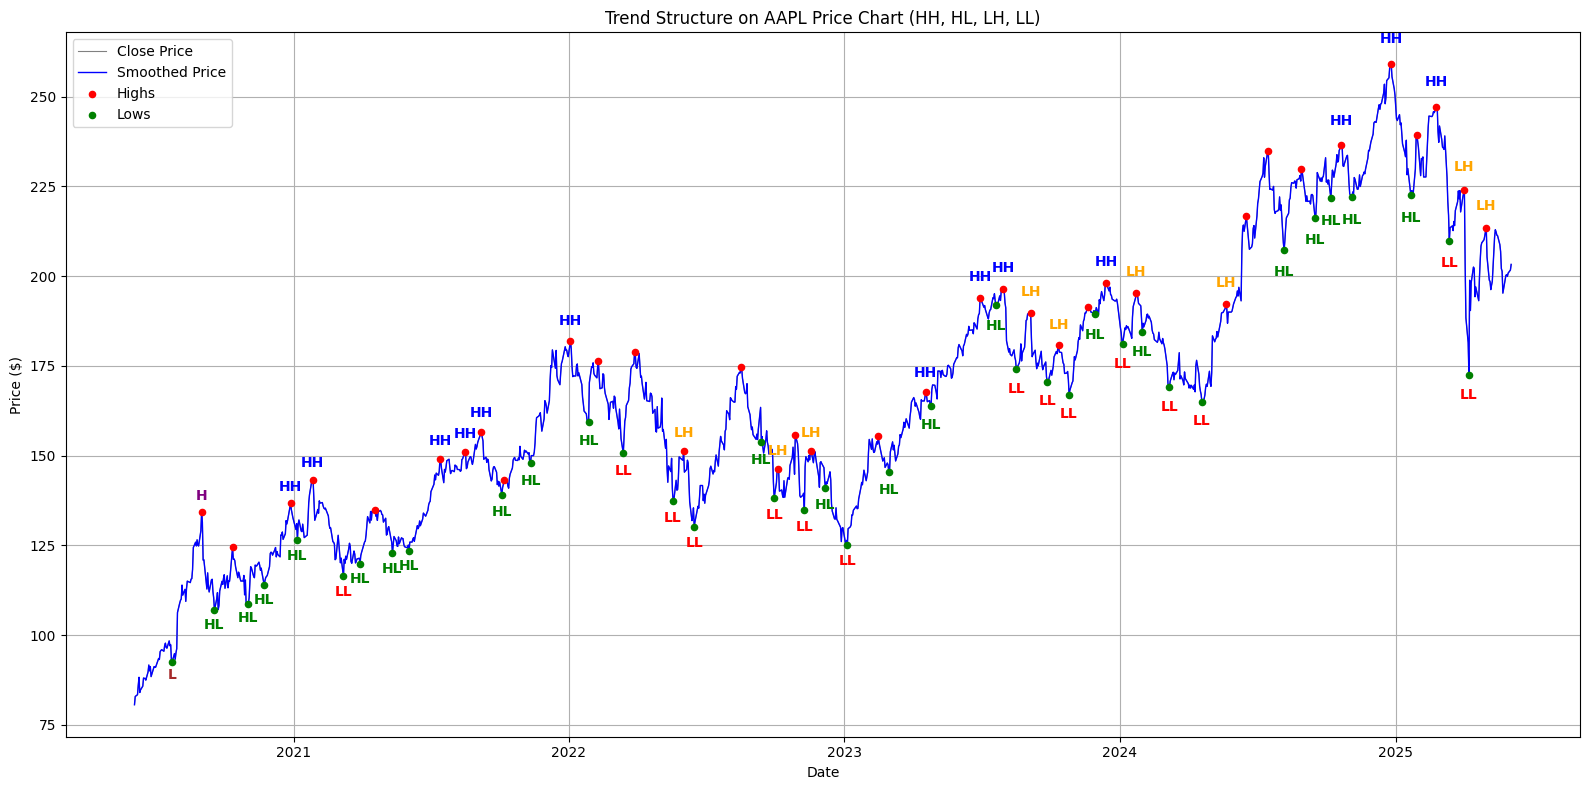

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df, df_inflex, and structure_df are already prepared

# Define label colors
label_colors = {
    'HH': 'blue',
    'HL': 'green',
    'LH': 'orange',
    'LL': 'red',
    'H': 'purple',  # Initial high
    'L': 'brown'    # Initial low
}

plt.figure(figsize=(16, 8))
plt.plot(df["Date"], df["Close/Last"], label="Close Price", color='gray', linewidth=0.8)
plt.plot(df["Date"], df["Close_Smooth"], label="Smoothed Price", color='blue', linewidth=1)

# Extract highs and lows from df_inflex
highs = df_inflex[df_inflex["point"] == "high"]
lows = df_inflex[df_inflex["point"] == "low"]

# Plot highs and lows with smaller dots
plt.scatter(highs["Date"], highs["InflexionPrice"], color='red', label="Highs", s=20, zorder=5)
plt.scatter(lows["Date"], lows["InflexionPrice"], color='green', label="Lows", s=20, zorder=5)

# Track first occurrence of standalone 'H' and 'L'
h_l_shown = {'H': False, 'L': False}

# Label the structure points (HH, HL, LH, LL)
for _, row in structure_df.iterrows():
    date = df.loc[row['index'], 'Date']
    price = row['price']
    label = row['label']
    
    # Skip standalone 'H' or 'L' except the first time
    if label in ['H', 'L']:
        if h_l_shown[label]:
            continue
        else:
            h_l_shown[label] = True
    
    color = label_colors.get(label, 'black')

    # Define highs and lows explicitly
    high_labels = ['H', 'HH', 'LH']
    low_labels = ['L', 'HL', 'LL']

    if label in low_labels:
        y_offset = -price * 0.02
        va = 'top'
    else:
        y_offset = price * 0.02
        va = 'bottom'

    plt.text(date, price + y_offset, label, color=color, fontsize=10, fontweight='bold',
             ha='center', va=va)

plt.title("Trend Structure on AAPL Price Chart (HH, HL, LH, LL)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [48]:
def detect_trends(df_inflex):
    trends = []
    last_high = None
    last_low = None
    current_trend = 'sideways'

    for i in range(1, len(df_inflex)):
        row = df_inflex.iloc[i]
        prev_row = df_inflex.iloc[i - 1]

        if row['point'] == 'high' and prev_row['point'] == 'low':
            if last_high is not None and last_low is not None:
                if row['InflexionPrice'] > last_high and prev_row['InflexionPrice'] > last_low:
                    current_trend = 'bullish'
            last_high = row['InflexionPrice']
            last_low = prev_row['InflexionPrice']

        elif row['point'] == 'low' and prev_row['point'] == 'high':
            if last_high is not None and last_low is not None:
                if row['InflexionPrice'] < last_low and prev_row['InflexionPrice'] < last_high:
                    current_trend = 'bearish'
            last_low = row['InflexionPrice']
            last_high = prev_row['InflexionPrice']

        trends.append({
            'StartDate': prev_row['Date'],
            'EndDate': row['Date'],
            'StartPrice': prev_row['InflexionPrice'],
            'EndPrice': row['InflexionPrice'],
            'Trend': current_trend
        })

    return pd.DataFrame(trends)
trend_segments = detect_trends(df_inflex)

#### Visualization

#### Generate Summary Report

#### Improvements

1. Reduce the Window Size (Most Important)
Smaller window = less smoothing = closer fit to actual data
Instead of window=49, try:
window=21  # Much closer fit
window=15  # Even closer
window=9   # Very close to actual data

2. Increase the Polynomial Order
Higher polynomial = more flexible curve
Instead of polyorder=5, try:
polyorder=7   # More flexible
polyorder=9   # Even more flexible
Note: polyorder must be less than window size